In [2]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.model_selection import KFold, cross_validate, RandomizedSearchCV

# 1. Prepare your data
df = pd.read_csv('Student_performance_data.txt', sep=',')
df.columns = df.columns.str.strip()
X = df.drop(columns=['StudentID','GradeClass', 'GPA'])
y = df['GPA']

# 2. Define parameter grids
param_dist_rf = {
    'n_estimators':      [100, 200, 500],
    'max_depth':         [5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf':  [1, 2, 4]
}
param_dist_xgb = {
    'n_estimators':      [100, 200, 500],
    'max_depth':         [3, 5, 7],
    'learning_rate':     [0.01, 0.05, 0.1],
    'subsample':         [0.6, 0.8, 1.0],
    'colsample_bytree':  [0.6, 0.8, 1.0]
}

# 3. Nested CV setup
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)

search_rf = RandomizedSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions=param_dist_rf,
    n_iter=10,
    scoring='neg_root_mean_squared_error',
    cv=inner_cv,
    random_state=42,
    n_jobs=-1,
    refit=True
)

search_xgb = RandomizedSearchCV(
    xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1),
    param_distributions=param_dist_xgb,
    n_iter=10,
    scoring='neg_root_mean_squared_error',
    cv=inner_cv,
    random_state=42,
    n_jobs=-1,
    refit=True
)

scoring = {
    'RMSE': 'neg_root_mean_squared_error',
    'MAE':  'neg_mean_absolute_error',
    'R2':   'r2'
}

# 4. Run nested CV and keep the fitted search objects
nested_cv_rf = cross_validate(
    search_rf, X, y,
    cv=outer_cv,
    scoring=scoring,
    n_jobs=-1,
    return_estimator=True    # ### CHANGED
)

nested_cv_xgb = cross_validate(
    search_xgb, X, y,
    cv=outer_cv,
    scoring=scoring,
    n_jobs=-1,
    return_estimator=True    # ### CHANGED
)

# 5. Extract best params from each outer fold
rf_best_params = [est.best_params_ for est in nested_cv_rf['estimator']]
xgb_best_params = [est.best_params_ for est in nested_cv_xgb['estimator']]

print("Best RandomForest params per outer fold:")
for i, p in enumerate(rf_best_params, 1):
    print(f" Fold {i}: {p}")

print("\nBest XGBoost params per outer fold:")
for i, p in enumerate(xgb_best_params, 1):
    print(f" Fold {i}: {p}")

# 6. Aggregate results as before
def summarize_cv(cv_res):
    return {
        'RMSE_mean': -np.mean(cv_res['test_RMSE']),
        'RMSE_std':   np.std( cv_res['test_RMSE']),
        'MAE_mean':  -np.mean(cv_res['test_MAE']),
        'MAE_std':    np.std( cv_res['test_MAE']),
        'R2_mean':    np.mean(cv_res['test_R2']),
        'R2_std':     np.std( cv_res['test_R2']),
    }

res_rf  = summarize_cv(nested_cv_rf)
res_xgb = summarize_cv(nested_cv_xgb)

df_cv = pd.DataFrame({
    'RandomForest_NestedCV': pd.Series(res_rf),
    'XGBoost_NestedCV':      pd.Series(res_xgb)
}).T.rename(columns={
    'RMSE_mean':'RMSE (μ)', 'RMSE_std':'RMSE (σ)',
    'MAE_mean':'MAE (μ)',   'MAE_std':'MAE (σ)',
    'R2_mean':'R² (μ)',     'R2_std':'R² (σ)',
})

print("\nNested CV Model Comparison:\n")
print(df_cv.round(4))


Best RandomForest params per outer fold:
 Fold 1: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 10}
 Fold 2: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 10}
 Fold 3: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 10}
 Fold 4: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 10}
 Fold 5: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 10}

Best XGBoost params per outer fold:
 Fold 1: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
 Fold 2: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
 Fold 3: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
 Fold 4: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytr

In [40]:
xgb_model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=-1, num_parallel_tree=None, ...)

In [ ]:
import pandas as pd
import xgboost as xgb

# 1. Load data
df = pd.read_csv('Student_performance_data.txt', sep=',')
df.columns = df.columns.str.strip()

# 2. Prepare features and target
X = df.drop(columns=['StudentID', 'GradeClass', 'GPA'])
y = df['GPA']

# 3. Instantiate and train XGBoost with best hyperparameters
xgb_model = xgb.XGBRegressor(
    subsample=1.0,
    n_estimators=200,
    max_depth=3,
    learning_rate=0.05,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X, y)


              feature  mean_abs_shap  mean_shap
5            Absences         0.7205    -0.0078
4     StudyTimeWeekly         0.1349     0.0095
7     ParentalSupport         0.1255     0.0273
6            Tutoring         0.0969    -0.0009
8     Extracurricular         0.0858    -0.0183
9              Sports         0.0745    -0.0077
10              Music         0.0409    -0.0038
3   ParentalEducation         0.0033    -0.0008
0                 Age         0.0027    -0.0003
1              Gender         0.0024     0.0002
2           Ethnicity         0.0008    -0.0002
11       Volunteering         0.0006    -0.0002


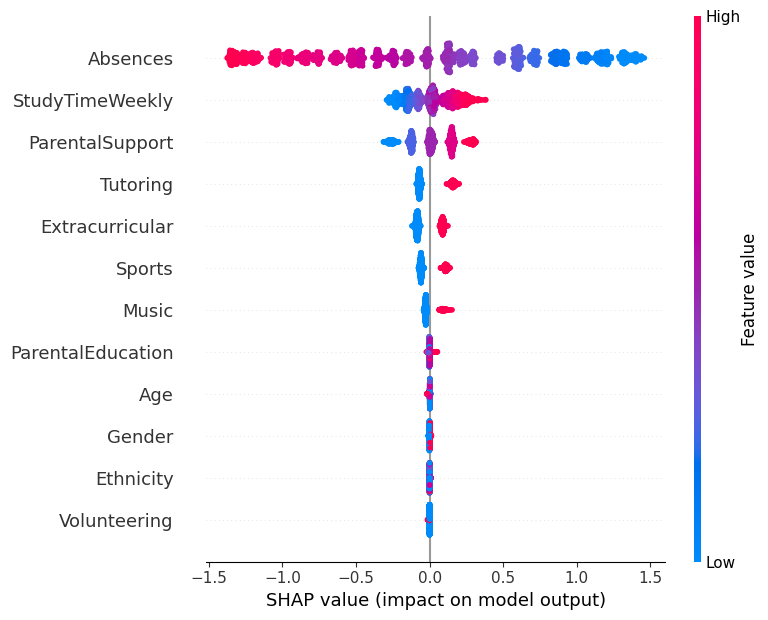

In [33]:
import shap

# 1. Create a SHAP explainer for your XGBoost model
explainer = shap.Explainer(xgb_model, X)

# 2. Compute SHAP values for every instance in X
shap_values = explainer(X)

# 3. Get a global importance table
#    mean_abs: average |SHAP| per feature
#    mean:     average signed SHAP per feature
import numpy as np
feature_names = X.columns.tolist()
shap_arr = shap_values.values  # shape (n_samples, n_features)

summary = {
    'feature': feature_names,
    'mean_abs_shap': np.abs(shap_arr).mean(axis=0),
    'mean_shap':     shap_arr.mean(axis=0)
}
shap_summary = pd.DataFrame(summary).sort_values(
    by='mean_abs_shap', ascending=False
)
print(shap_summary)

# 4. (Optional) Visual summary
shap.summary_plot(shap_values, X)



--- Student 3387.0 (Predicted GPA 1.922) ---
          feature    value  shap_value
         Absences  14.0000      0.2502
  StudyTimeWeekly  13.8140      0.1083
  Extracurricular   0.0000     -0.0657
         Tutoring   0.0000     -0.0638
           Sports   0.0000     -0.0583
  ParentalSupport   2.0000     -0.0365
            Music   0.0000     -0.0184
ParentalEducation   2.0000      0.0015
     Volunteering   0.0000      0.0001


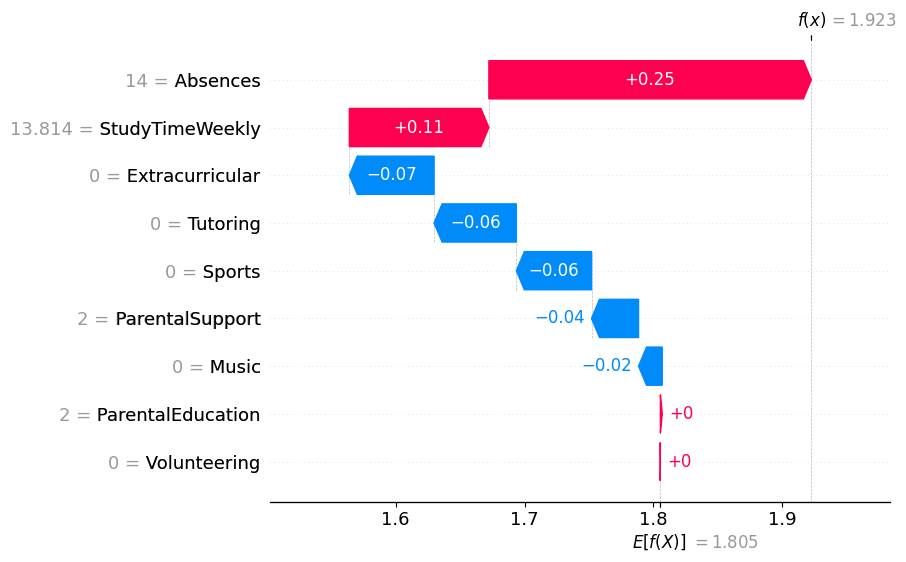


--- Student 3388.0 (Predicted GPA 3.352) ---
          feature    value  shap_value
         Absences   2.0000      1.3222
  ParentalSupport   4.0000      0.2525
  Extracurricular   1.0000      0.1059
         Tutoring   0.0000     -0.0724
           Sports   0.0000     -0.0534
            Music   0.0000     -0.0172
  StudyTimeWeekly  10.6806      0.0100
ParentalEducation   3.0000     -0.0007
     Volunteering   0.0000      0.0003


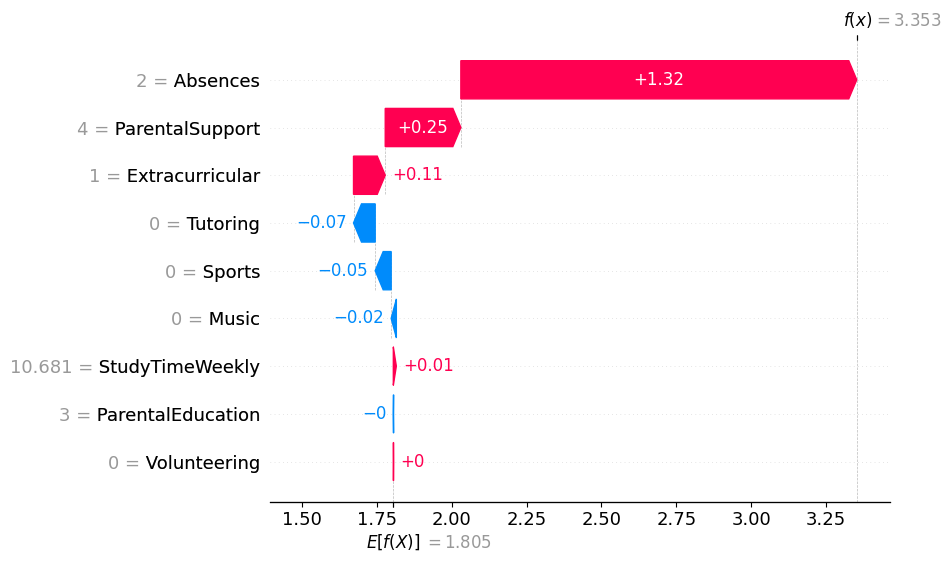


--- Student 3389.0 (Predicted GPA 3.400) ---
          feature   value  shap_value
         Absences  4.0000      1.2110
  ParentalSupport  4.0000      0.2692
         Tutoring  1.0000      0.1833
           Sports  1.0000      0.1011
  StudyTimeWeekly  7.5832     -0.0795
  Extracurricular  0.0000     -0.0632
            Music  0.0000     -0.0238
ParentalEducation  1.0000     -0.0043
     Volunteering  0.0000      0.0003


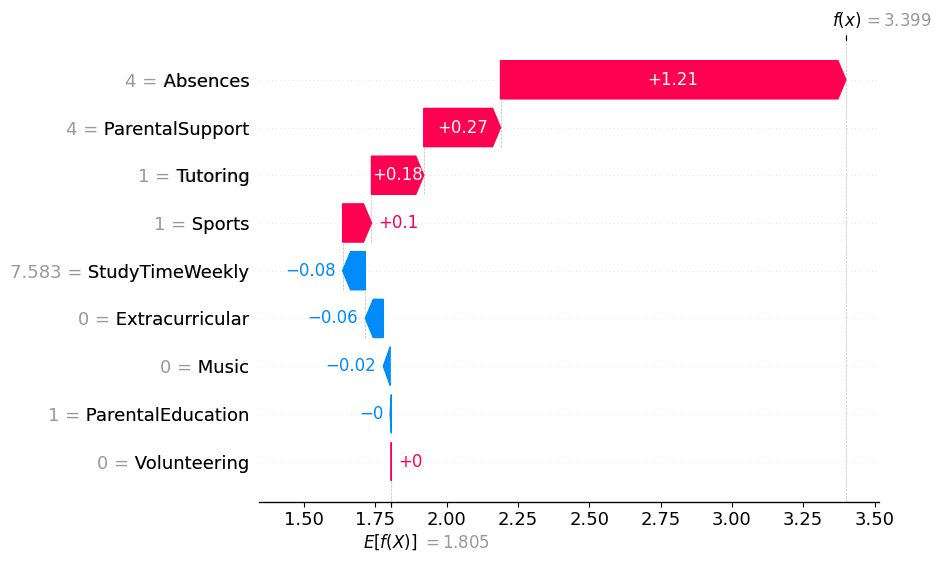


--- Student 3390.0 (Predicted GPA 1.073) ---
          feature    value  shap_value
         Absences  20.0000     -0.3938
  StudyTimeWeekly   6.8055     -0.0860
         Tutoring   0.0000     -0.0741
  Extracurricular   0.0000     -0.0677
           Sports   0.0000     -0.0581
  ParentalSupport   2.0000     -0.0388
            Music   0.0000     -0.0174
     Volunteering   1.0000     -0.0014
ParentalEducation   2.0000      0.0014


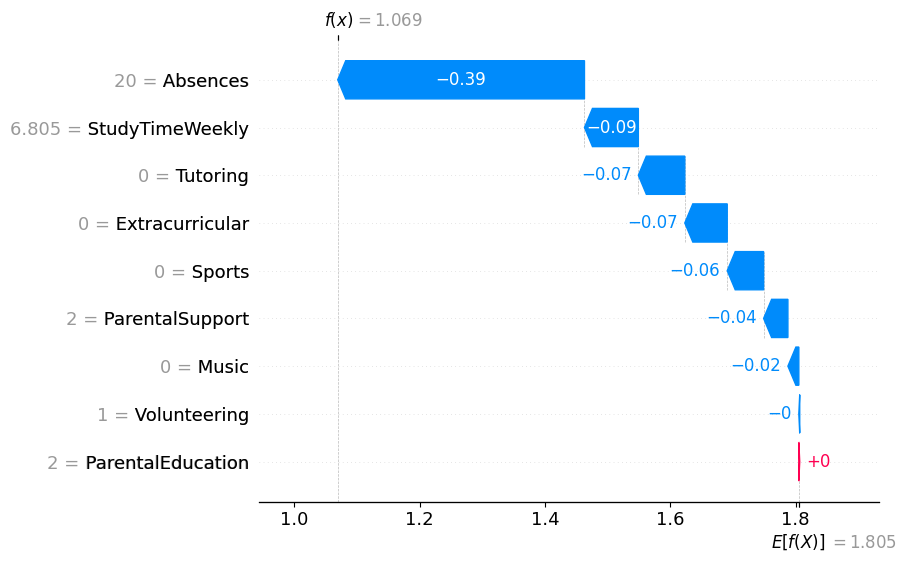


--- Student 3391.0 (Predicted GPA 1.846) ---
          feature    value  shap_value
         Absences  17.0000     -0.1316
           Sports   1.0000      0.1252
            Music   1.0000      0.1113
  StudyTimeWeekly  12.4167      0.0946
  Extracurricular   0.0000     -0.0670
         Tutoring   0.0000     -0.0589
  ParentalSupport   2.0000     -0.0352
     Volunteering   0.0000      0.0001
ParentalEducation   0.0000     -0.0001


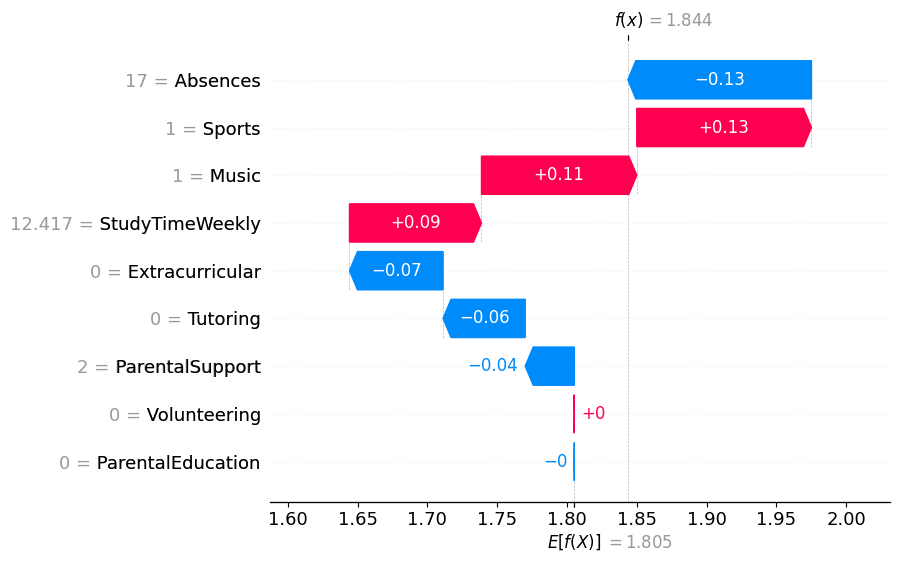


--- Student 3392.0 (Predicted GPA 2.062) ---
          feature    value  shap_value
         Absences  13.0000      0.2498
  StudyTimeWeekly  17.8199      0.2255
  Extracurricular   0.0000     -0.0632
         Tutoring   0.0000     -0.0626
           Sports   0.0000     -0.0560
  ParentalSupport   2.0000     -0.0212
            Music   0.0000     -0.0192
ParentalEducation   2.0000      0.0020
     Volunteering   1.0000     -0.0013


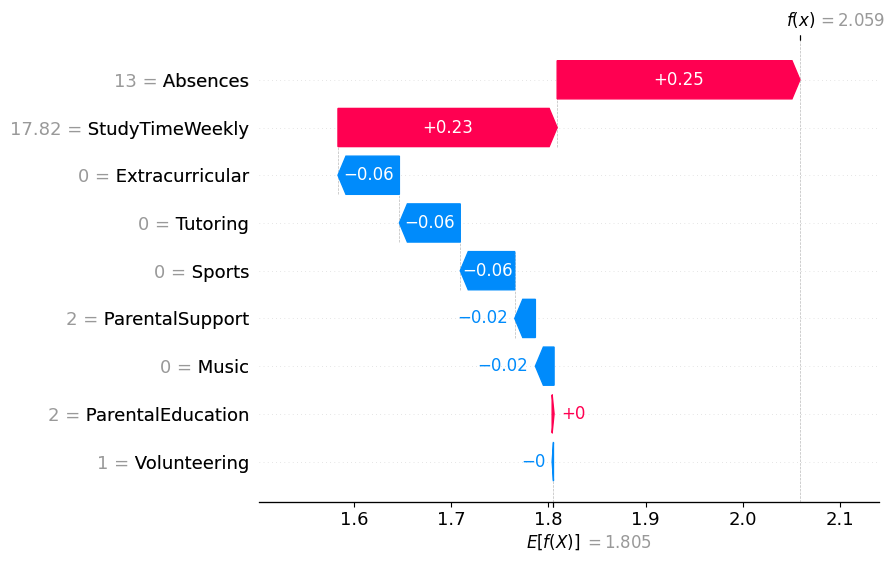

In [43]:
import pandas as pd
import numpy as np
import shap

xgb_model.fit(X, y)   # your final model

# --- 2. Build a SHAP explainer using the full training data as background ---
explainer = shap.Explainer(xgb_model, X)

# --- 3. Load the “new” students whose GPA you want to predict/explain ---
new_students = pd.read_csv('test.txt', sep=',')
new_students.columns = new_students.columns.str.strip()

for _, row in new_students.iterrows():
    student_id = row['StudentID']
    feat = row.drop(['StudentID','GPA','GradeClass'])
    feat_df = feat.to_frame().T

    # 1) Predict
    pred_gpa = xgb_model.predict(feat_df)[0]

    # 2) Compute SHAP
    shap_vals = explainer(feat_df)

    # 3) Build a contributions DataFrame, then drop Age & Gender
    contrib = pd.DataFrame({
        'feature':     feat_df.columns,
        'value':       feat_df.values[0],
        'shap_value':  shap_vals.values[0],
    })
    contrib = contrib[~contrib['feature'].isin(['Age','Gender', 'Ethnicity'])]
    contrib = contrib.reindex(contrib.shap_value.abs().sort_values(ascending=False).index)

    print(f"\n--- Student {student_id} (Predicted GPA {pred_gpa:.3f}) ---")
    print(contrib.to_string(index=False))

    # 4) Waterfall without Age & Gender
    #    (rebuild a mini–Explanation object that only contains the other features)
    mask = [f not in ('Age','Gender', 'Ethnicity') for f in feat_df.columns]
    expl_sub = shap.Explanation(
        values       = shap_vals.values[0][mask],
        base_values  = shap_vals.base_values[0],
        data         = feat_df.values[0][mask],
        feature_names= np.array(feat_df.columns)[mask]
    )
    shap.plots.waterfall(expl_sub)


In [ ]:
import os
import openai
import pandas as pd

# 1. Ensure your contrib DataFrame is ready
#    contrib = pd.DataFrame({ 'feature': [...], 'value': [...], 'shap_value': [...] })

# 2. Convert it to Markdown for readability
table_md = contrib.to_markdown(index=False)

# 3. Configure your API key (export OPENAI_API_KEY in your env)
os.environ["OPENAI_API_KEY"] = 
openai_client = OpenAI()
openai_client.api_key = os.getenv("OPENAI_API_KEY")


# 4. Build the system + user messages
messages = [
    {
        "role": "system",
        "content": (
            "You are an experienced academic advisor. "
            "Given SHAP contributions for a student’s GPA, "
            "you’ll suggest realistic adjustments (study habits, parental involvement, extracurriculars) "
            "to help them improve their predicted GPA."
        )
    },
    {
        "role": "user",
        "content": (
            "Here are the SHAP feature contributions for one student:\n\n"
            + table_md +
            "\n\n"
            "Please provide **5 specific, actionable suggestions** the student could follow to increase their GPA, "
            "explaining *why* each suggestion matters (i.e. which feature it addresses)."
        )
    }
]

# 5. Call the ChatCompletion API
resp = openai_client.chat.completions.create(
    model="gpt-4o",        # or "gpt-4" if you have access
    messages=messages,
    temperature=0.7
)

# 6. Print advisor’s suggestions
print(resp.choices[0].message.content)


In [48]:
import os
import openai
import pandas as pd
from openai import OpenAI

# Assume `contrib` DataFrame and `pred_gpa` are already computed:
# contrib = pd.DataFrame({ 'feature': [...], 'value': [...], 'shap_value': [...] })
# pred_gpa = xgb_model.predict(feat_df)[0]

# Convert SHAP contributions to Markdown
table_md = contrib.to_markdown(index=False)

# Configure API key
os.environ["OPENAI_API_KEY"] = 
openai_client.api_key = os.getenv("OPENAI_API_KEY")

# Build messages with student‑friendly structure
messages = [
    {
        "role": "system",
        "content": (
            "You are a friendly and supportive academic advisor speaking directly to a student. "
            "First, share the student’s predicted GPA. Then highlight what the student is already doing well, "
            "and finally suggest concrete improvements to raise the GPA further."
        )
    },
    {
        "role": "user",
        "content": (
            f"Hi! Based on your profile, your predicted GPA is **{pred_gpa:.2f}**.\n\n"
            "Below are the key factors influencing your GPA (positive values help, negative values hurt):\n\n"
            + table_md +
            "\n\n"
            "Please:\n"
            "1. Affirm the areas where you’re performing strongly.\n"
            "2. Identify 3–5 specific actions you can take to improve weaker areas.\n"
            "3. Explain *why* each action matters in terms of the features above.\n\n"
            "Write in a supportive, student‑friendly tone."
        )
    }
]

# Call the API
resp = openai_client.chat.completions.create(
    model="gpt-4o",
    messages=messages,
    temperature=0.7,
    max_tokens=400
)

print(resp.choices[0].message.content)


Hi there! Let's take a look at your academic journey together. Your predicted GPA is **2.06**, and while there's room for improvement, there's also a lot you're doing well! Let's start by celebrating your successes.

### What You're Doing Well:
- **Study Time**: You're dedicating a significant amount of time to studying each week, which is fantastic! This is a key factor that positively influences your GPA. Keep up the good work here, as consistent study habits will continue to benefit you.
- **Absences**: Your attendance is pretty solid, which is great since being present in class is crucial for understanding the material and staying engaged.

### Areas for Improvement & Suggestions:

1. **Get Involved in Extracurricular Activities**:
   - **Why it matters**: Engaging in extracurricular activities can help develop time management skills, enhance your resume, and provide networking opportunities.
   - **Action**: Consider joining a club or organization that interests you. This could al